**STEP 1 — Import libraries**

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance


**STEP 2 — Load the dataset**

In [32]:
df = pd.read_csv("car data.csv", encoding="latin1")

print(df.head())


  Car_Name  Year  Selling_Price  Present_Price  Driven_kms Fuel_Type  \
0     ritz  2014           3.35           5.59       27000    Petrol   
1      sx4  2013           4.75           9.54       43000    Diesel   
2     ciaz  2017           7.25           9.85        6900    Petrol   
3  wagon r  2011           2.85           4.15        5200    Petrol   
4    swift  2014           4.60           6.87       42450    Diesel   

  Selling_type Transmission  Owner  
0       Dealer       Manual      0  
1       Dealer       Manual      0  
2       Dealer       Manual      0  
3       Dealer       Manual      0  
4       Dealer       Manual      0  


In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Driven_kms     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Selling_type   301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB
None


In [33]:
print(df.describe())

              Year  Selling_Price  Present_Price     Driven_kms       Owner
count   301.000000     301.000000     301.000000     301.000000  301.000000
mean   2013.627907       4.661296       7.628472   36947.205980    0.043189
std       2.891554       5.082812       8.642584   38886.883882    0.247915
min    2003.000000       0.100000       0.320000     500.000000    0.000000
25%    2012.000000       0.900000       1.200000   15000.000000    0.000000
50%    2014.000000       3.600000       6.400000   32000.000000    0.000000
75%    2016.000000       6.000000       9.900000   48767.000000    0.000000
max    2018.000000      35.000000      92.600000  500000.000000    3.000000


**STEP 3 — Identify target column (Price)**

In [34]:
possible_targets = ["price", "Price", "selling_price", "Selling_Price", "Sale_Price"]
target_col = None

for c in df.columns:
    if c in possible_targets:
        target_col = c
        break

# fallback (last numeric column)
if target_col is None:
    numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    target_col = numeric_cols[-1]

print("Target column →", target_col)


Target column → Selling_Price


**STEP 4 — Prepare features & target**

In [35]:
df = df.dropna(subset=[target_col])

X = df.drop(columns=[target_col])
y = df[target_col].astype(float)

numeric_features = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
categorical_features = [c for c in X.columns if c not in numeric_features]

print("Numeric:", numeric_features)
print("Categorical:", categorical_features)


Numeric: ['Year', 'Present_Price', 'Driven_kms', 'Owner']
Categorical: ['Car_Name', 'Fuel_Type', 'Selling_type', 'Transmission']


**STEP 5 — Preprocessing pipeline**

In [36]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


**STEP 6 — Train/Test split**

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


**STEP 7 — Build models**

In [38]:
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=200, random_state=42)
}


**STEP 8 — Train & evaluate each model**

In [39]:
def evaluate(model, name):
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))   
    r2 = r2_score(y_test, y_pred)

    print("\n======", name, "======")
    print("MAE :", mae)
    print("RMSE:", rmse)
    print("R2  :", r2)

    return pipe, y_pred


trained_models = {}
predictions = {}

for name, model in models.items():
    trained, pred = evaluate(model, name)
    trained_models[name] = trained
    predictions[name] = pred



====== LinearRegression ======
MAE : 1.1038461871503213
RMSE: 1.5125567417841355
R2  : 0.9006828806492203

====== RandomForest ======
MAE : 0.6029204918032777
RMSE: 0.9101444330749789
R2  : 0.9640398580583994

====== GradientBoosting ======
MAE : 0.5489944070132373
RMSE: 0.9216742752229057
R2  : 0.9631229904819899


**STEP 9 — Choose best model**

In [40]:

rmse_scores = {
    name: float(np.sqrt(mean_squared_error(y_test, pred)))
    for name, pred in predictions.items()
}

print("\nModel RMSE on test set:")
for name, val in rmse_scores.items():
    print(f" {name}: {val:.4f}")

# choose best model by lowest RMSE
best_model_name = min(rmse_scores, key=rmse_scores.get)
best_model = trained_models[best_model_name]
best_pred = predictions[best_model_name]

print("\nBest model →", best_model_name)



Model RMSE on test set:
 LinearRegression: 1.5126
 RandomForest: 0.9101
 GradientBoosting: 0.9217

Best model → RandomForest


**True vs Predicted plot**

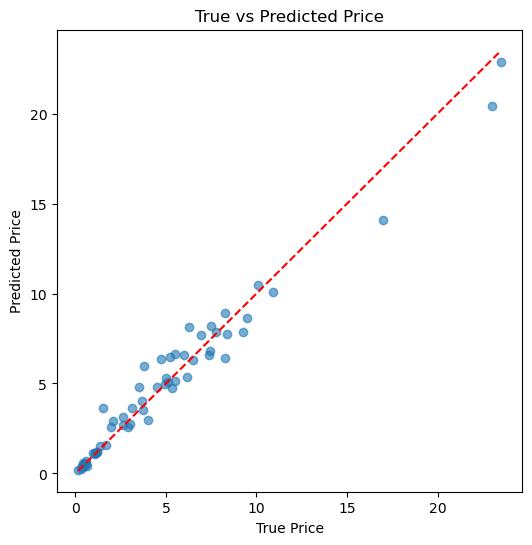

In [41]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, best_pred, alpha=0.6)
plt.xlabel("True Price")
plt.ylabel("Predicted Price")
plt.title("True vs Predicted Price")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], "r--")
plt.show()


**Boxplot: True vs Predicted Price Distribution**

C:\Users\ASUS\AppData\Local\Temp\ipykernel_5572\3651072988.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([y_test, best_pred], labels=["Actual Price", "Predicted Price"])


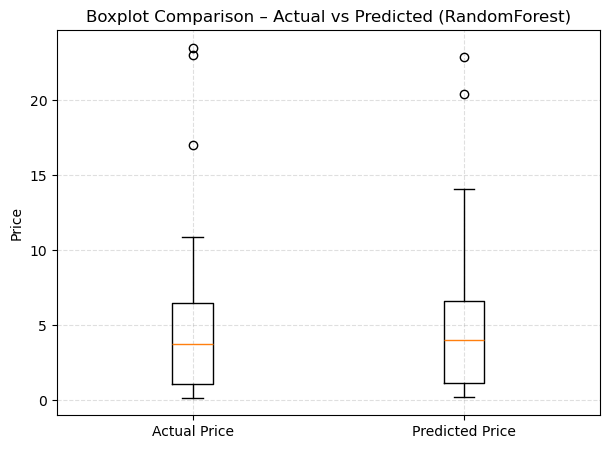

In [42]:
plt.figure(figsize=(7,5))
plt.boxplot([y_test, best_pred], labels=["Actual Price", "Predicted Price"])
plt.title(f"Boxplot Comparison – Actual vs Predicted ({best_model_name})")
plt.ylabel("Price")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()


**Correlation Heatmap of Numeric Features**

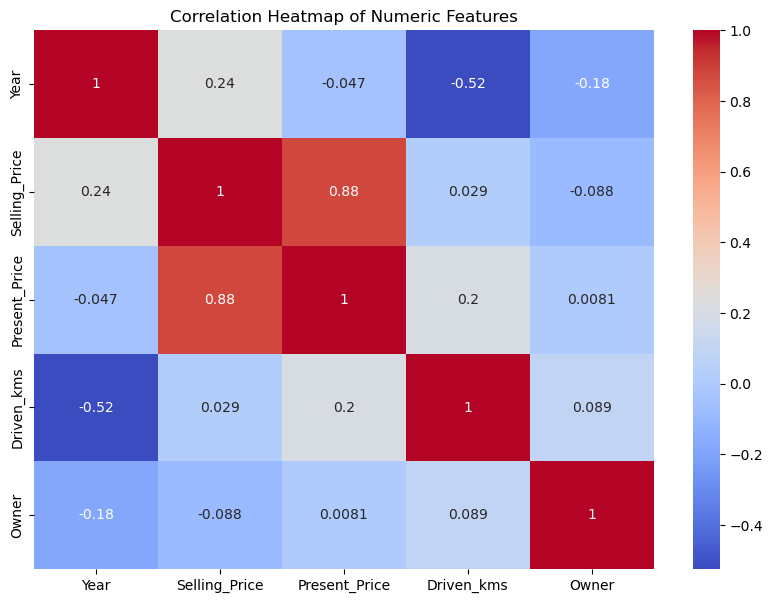

In [43]:
import seaborn as sns

plt.figure(figsize=(10,7))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()


**Residual plot**

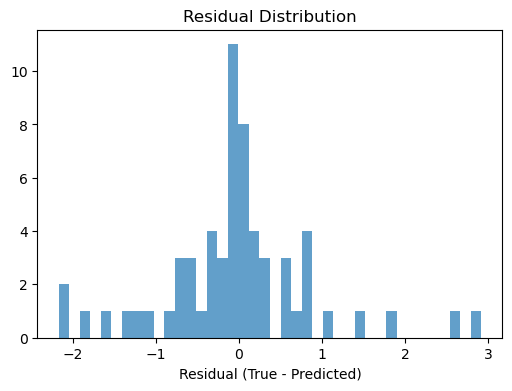

In [44]:
residuals = y_test - best_pred

plt.figure(figsize=(6,4))
plt.hist(residuals, bins=40, alpha=0.7)
plt.title("Residual Distribution")
plt.xlabel("Residual (True - Predicted)")
plt.show()


**Feature importance (only for tree models)**


Calculating feature importance...


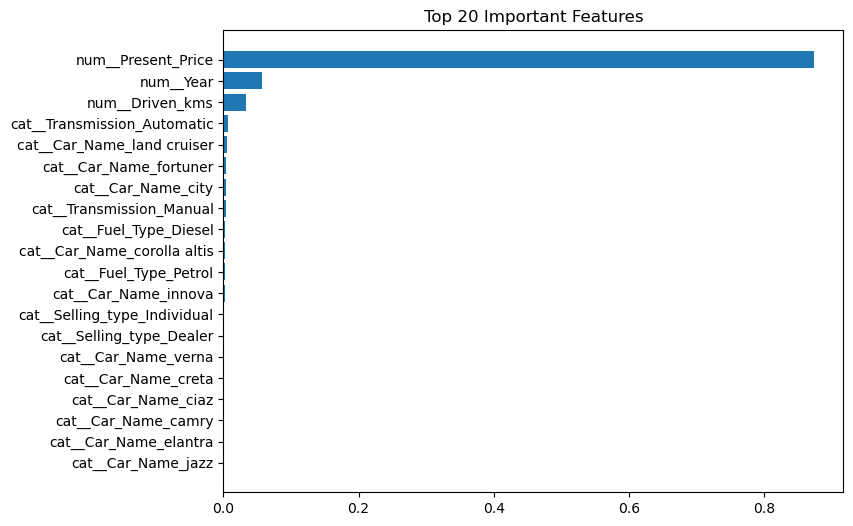

In [45]:
if "RandomForest" in trained_models:
    model = trained_models["RandomForest"].named_steps["model"]

    print("\nCalculating feature importance...")

    full_processed = trained_models["RandomForest"].named_steps["preprocessor"]
    feature_names = full_processed.get_feature_names_out()

    importances = model.feature_importances_
    idx = np.argsort(importances)[-20:]

    plt.figure(figsize=(8,6))
    plt.barh(feature_names[idx], importances[idx])
    plt.title("Top 20 Important Features")
    plt.show()
